In [1]:
import json
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from functools import lru_cache

import add_path
from toolkit.pipeline.data_io import SessionDirectory
from toolkit.utils.misc import pd_merge_differences
from toolkit.analysis.utils import get_bins
from toolkit.analysis.spikes import spike_count
from toolkit.pipeline.units import evoke_rate_test, OPTO_EVOKE_KEYS

pd.set_option('display.max_columns', None)

with open('config.json') as f:
    config = json.load(f)

## Get session and load data

In [2]:
session_id = config['session_id']
ecephys_structure_acronym = config['ecephys_structure_acronym']
print(f"Session ID: {session_id}")

Session ID: 766640955


In [3]:
session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

probe_info = session_dir.load_probe_info()
if not session_dir.has_lfp_data:
    raise ValueError(f"Session {session_id} has no LFP data")

lfp_channels = session_dir.load_lfp_channels()

session = session_dir.session

c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


## Get units dataframe and nearby channels

In [ ]:
units = session.units
sel_units_idx = units['probe_id'] == probe_info['probe_id']
sel_units_idx = sel_units_idx & (units['ecephys_structure_acronym'] == ecephys_structure_acronym)
sel_units = units[sel_units_idx]

c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [ ]:
nearby_channel_min_distance = 200  # nearby channel at least this distance apart
min_vertical_distance = 10  # minimum vertical distance to consider as the same vertical position
offsets = dict(
    lfp_channel = 0.,
    lower_lfp_channel = -nearby_channel_min_distance,
    upper_lfp_channel = nearby_channel_min_distance
)

@lru_cache(maxsize=128)
def nearest_lfp_channel(x):
    """Return the index of the nearest LFP channel to vertical position x and if a channel exists at x."""
    d = (lfp_channels['probe_vertical_position'] - x).abs()
    idx = d.idxmin()
    return idx, d.loc[idx] <= min_vertical_distance

units_lfp_channels = []
for x in sel_units['probe_vertical_position'].values:
    unit_lfp_channels = {}
    for s, offset in offsets.items():
        unit_lfp_channels[s + '_id'], unit_lfp_channels[s + '_exists'] = nearest_lfp_channel(x + offset)
    units_lfp_channels.append(unit_lfp_channels)
units_lfp_channels = pd.DataFrame(units_lfp_channels, index=sel_units.index)
units_lfp_channels['layer_acronym'] = lfp_channels.loc[units_lfp_channels['lfp_channel_id'], 'layer_acronym'].values

sel_units = pd_merge_differences(sel_units, units_lfp_channels, left_index=True, right_index=True, how='left')

## Get units optotagging info

In [ ]:
def optotagging_spike_rate(spike_times, opto_trials, unit_ids, bin_width=0.03, window=(-1.0, 1.0)):
    """Count spikes in bins for each optotagging trial"""
    bin_centers, bin_edges = get_bins(window, bin_width=bin_width)
    trial_start_times = np.asarray(opto_trials['start_time'])
    unit_ids = np.asarray(unit_ids)

    units_spk_counts = np.zeros((trial_start_times.size, bin_centers.size, unit_ids.size), dtype=int)
    for i, unit_id, in enumerate(unit_ids):
        tspk = spike_times[unit_id]
        for j, trial_start in enumerate(trial_start_times):
            t = tspk[(tspk >= trial_start + bin_edges[0]) & (tspk <= trial_start + bin_edges[-1])]
            units_spk_counts[j, :, i] = spike_count(t - trial_start, bin_edges)

    units_spk_rate = xr.DataArray(data=units_spk_counts / bin_width, coords=dict(
        trial_id=opto_trials.index.values, time_relative_to_stimulus_onset=bin_centers, unit_id=unit_ids),
        name='spike_rate', attrs=dict(bin_width=bin_width))
    return units_spk_rate

In [ ]:
bin_width = 0.0005  # 0.5 ms bins
window = (-0.010, 0.020)  # ms

baseline_window = (-0.010, -0.001)
evoked_window = (0.001, 0.010)

try:
    opto_epochs = session.optogenetic_stimulation_epochs
except Exception as e:
    print(f"Error getting `session.optogenetic_stimulation_epochs`: {e}")
    spike_rate = None
else:
    # get trials with duration 10 ms (a single square pulse)
    trials = opto_epochs[(opto_epochs.duration > 0.009) & (opto_epochs.duration < 0.02)]
    spike_rate = optotagging_spike_rate(session.spike_times, trials, sel_units.index, bin_width=bin_width, window=window)

c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
c:\Users\chen8\.conda\envs\allen\lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


### Evoke rate and t-test

In [ ]:
if spike_rate is None:  # no opto stimulation data, fill with NaN
    evoke_df = pd.DataFrame(np.nan, index=sel_units.index, columns=OPTO_EVOKE_KEYS)
else:
    evoke_df = evoke_rate_test(spike_rate, baseline_window, evoked_window)
evoke_df['genotype'] = session_dir.genotype

sel_units = pd_merge_differences(sel_units, evoke_df, left_index=True, right_index=True, how='left')

### Save selected units info with optotagging results

In [11]:
session_dir.save_units_info(sel_units)

### Plot response firing rate

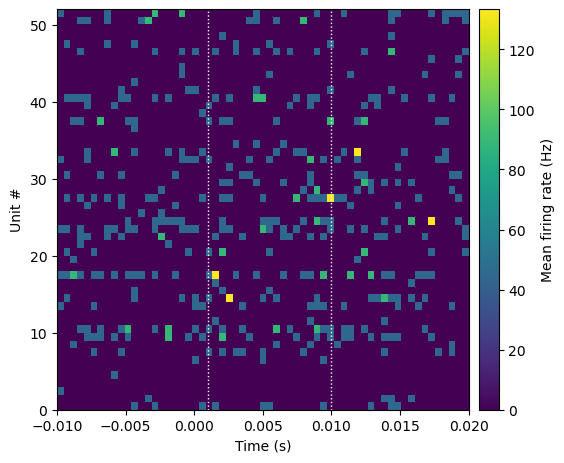

In [ ]:
def plot_optotagging_response(da, bounds=[]):
    n_unit = da.coords['unit_id'].size
    t = da.coords['time_relative_to_stimulus_onset']

    _, ax = plt.subplots(1, 1, figsize=(6.4, n_unit * 0.1))
    im = ax.imshow(da.mean(dim='trial_id').T, extent=[t[0], t[-1], 0, n_unit], aspect='auto')
    for bound in bounds:
        ax.axvline(bound, linestyle=':', color='w', linewidth=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Unit #')
    plt.colorbar(mappable=im, ax=ax, label='Mean firing rate (Hz)', pad=0.02)

plot_optotagging_response(spike_rate, bounds=evoked_window)

## Units optotag summary

In [4]:
sel_units = session_dir.load_units_info()
genotype = sel_units.iloc[0]['genotype']

### Evaluate optotagging

In [ ]:
from toolkit.pipeline.units import detect_optotag
from toolkit.plots.plots import plot_optotag_evoke_ratio, plot_optotag_units

min_rate = 1.  # Hz (minimum rate to avoid 0 firing rate)
evoked_ratio_threshold = 1.5  # threshold for ratio of evoked to baseline
ttest_alpha = 0.05  # alpha for t-test

spike_width_ranges = {'Pvalb': (-np.inf, 0.45), 'Sst': None, 'wt': None, 'Vip': None, 'RS': (0.45, np.inf)}  # ms. Spike width lower than this are PV
spike_width_range = spike_width_ranges[genotype]

optotag_df, positive_units = detect_optotag(
    sel_units, min_rate=min_rate, evoked_ratio_threshold=evoked_ratio_threshold,
    ttest_alpha=ttest_alpha, spike_width_range=spike_width_range
)

### Plot evoke ratio and significance

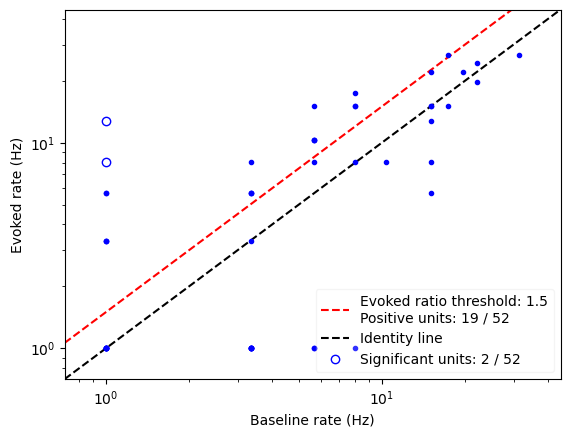

In [6]:
plot_optotag_evoke_ratio(optotag_df, min_rate=min_rate, evoked_ratio_threshold=evoked_ratio_threshold)
plt.show()

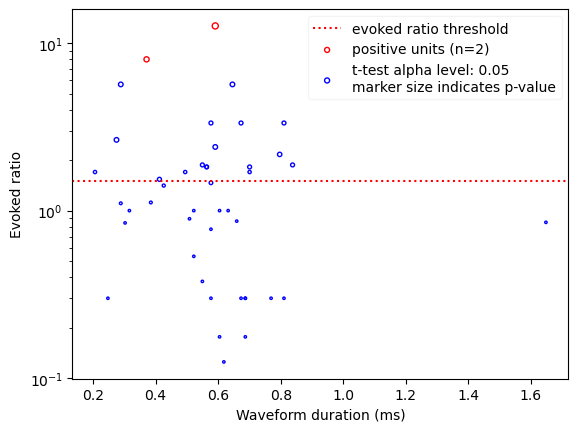

In [7]:
plot_optotag_units(optotag_df, ttest_alpha=ttest_alpha,
    evoked_ratio_threshold=evoked_ratio_threshold, spike_width_range=spike_width_range)
plt.show()